# Assignment 7: Variational Diffusion Models

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors. 

Recall the VAE setting and its ELBO objective. 
We had an encoder and a decoder and in between a latent representation $z \sim \mathcal N(0, I)$. 
Intuitively, the encoder maps data to noise and the decoder maps noise to data. 
In VAEs, observables $x$ and latents $z$ will usually have a different structure.

In contrast, a key idea of variational diffusion models (VDMs) is that observables and latents have the same structure. 
We highlight this fact by denoting the observables $x_0$ and the latents $x_T$. 
Now instead of mapping between $x_0$ and $x_T$ in one step, we add many intermediate steps. 
That is, we introduce a sequence $x_0, x_1, \dots, x_{T-1}, x_T$, where $x_0$ is a plain data sample, $x_1$ is a slightly noise-corrupted version of that sample, $x_2$ is a little more corrupted, and so on until $x_T$ is pure Gaussian noise. 

If we implement this idea in the full-fledged VAE setting, we need $T$ encoders and $T$ decoders. 
To reduce the number of parameters VDMs do two things, (1) they share the parameters across time steps and (2) they drop the encoder since corrupting data with noise is easy and we don't need a neural network for that. 
So instead of $2T$ models, we only need one, a decoder $p_{\theta}(x_t \mid x_{t+1})$ that learns to gradually denoise a noisy sample. 
The subscript $\theta$ indicates that this distribution is governed by the decoder parameters $\theta$. 
To generate a new data sample, we draw some noise $x_T$ and apply the decoder $T$ times. 

To summarize, the key ideas of VDMs are
- VDMs introduce a sequence $x_0, \dots, x_T$ from plain data to pure noise
- VDMs don't need encoders since noise corruption is easy
- VDMs share the decoder parameters across time steps


## Exercise 1: Forward Diffusion Simulation

The noise corruption or forward diffusion process is defined as
\begin{align*}
    p(x_t \mid x_{t-1}) &= \mathcal N(\sqrt \alpha x_{t-1}, (1-\alpha) I ) && \text{where} & \alpha &\in (0, 1) \subset \mathbb R. 
\end{align*}
If $\alpha$ is close to 1, we draw $x_t$ from a normal distribution with mean close to $x_{t-1}$ and small variance. 
Simulate and visualize the forward diffusion process using a sample image from the CIFAR10 dataset for $T=500$. 
By visual inspection, tune $\alpha$ to a value that lets $x_0$ smoothly blend into noise throughout the sequence.

In [1]:
import math
from math import sqrt
import numpy as np
import torch
import torchvision
import torchvision.transforms as tfm
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = (img + 1) / 2 # rescale from [-1, 1] to [0, 1]
    plt.imshow(np.transpose(img.numpy().clip(0, 1), (1, 2, 0)))
    plt.show()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tfm.ToTensor())
x = trainset[0][0] * 2 - 1 # scale to [-1, 1]

Files already downloaded and verified


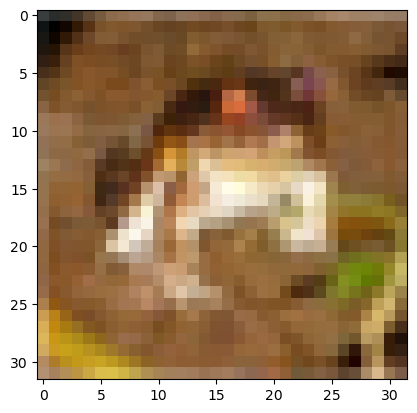

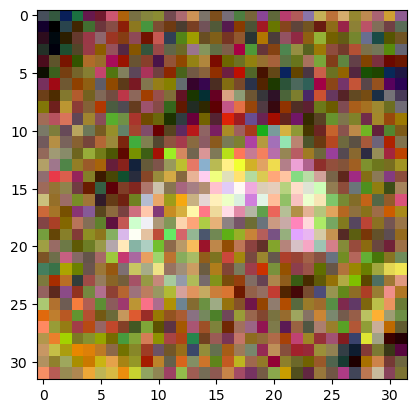

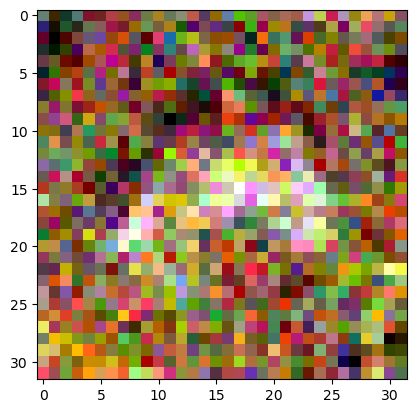

In [13]:
########## YOUR SOLUTION HERE ##########

def forward_diffusion_process(x_0, T, alpha):
    images = [x_0]
    current = x_0
    for t in range(1, T+1):
        noise = torch.randn_like(current) * math.sqrt(1 - alpha)
        current = sqrt(alpha) * current + noise
        images.append(current)
    return images


T = 500
alpha = 0.9997

images = forward_diffusion_process(x, T, alpha)

imshow(images[0])
imshow(images[250])
imshow(images[500])

## Exercise 2: Forward Diffusion Process

Again, the noise corruption or forward diffusion process is defined as
\begin{align*}
    p(x_t \mid x_{t-1}) &= \mathcal N(\sqrt \alpha x_{t-1}, (1-\alpha) I ) && \text{where} & \alpha &\in (0, 1) \subset \mathbb R. 
\end{align*}
Use the reparameterization trick to show that
\begin{align*}
    p(x_t \mid x_0) = \mathcal N(\sqrt{\alpha^t} x_0, (1-\alpha^t) I).
\end{align*}
From this result, interpret the role of the parameter $\alpha$. 
Why is $p(x_t \mid x_0)$ useful? 

########## YOUR SOLUTION HERE ##########

Given the forward diffusion process:

$$
p(x_t \mid x_{t-1}) = \mathcal{N}(\sqrt{\alpha} x_{t-1}, (1-\alpha) I),
$$

we want to express $p(x_t \mid x_0)$. We start by expanding $x_t$ from $x_{t-1}$, and then repeatedly apply the definition back to $x_0$:

$$
x_t = \sqrt{\alpha} x_{t-1} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, (1-\alpha)I),
$$

$$
x_{t-1} = \sqrt{\alpha} x_{t-2} + \epsilon_{t-1}, \quad \epsilon_{t-1} \sim \mathcal{N}(0, (1-\alpha)I),
$$

Which leads to:

$$
x_t = \sqrt{\alpha}(\sqrt{\alpha} x_{t-2} + \epsilon_{t-1}) + \epsilon_t = \alpha x_{t-2} + \sqrt{\alpha}\epsilon_{t-1} + \epsilon_t,
$$

It can be seen that we have a coefficient for $x$ and one for $\epsilon$ related to $t$:

$$
x_t = \alpha^{t/2} x_0 + \sum_{k=0}^{t-1} \alpha^{(t-k-1)/2} \epsilon_k.
$$

Since $x_t$ is a linear combination of Gaussian variables ( $x_0$ is a constant here), $x_t$ itself is Gaussian.
The mean $\mu_t$ of $x_t$ can be calculated so because the expected value of $\epsilon_k$ is zero.
$$
E[x_t] = \alpha^{t/2} x_0 + E\left[\sum_{k=0}^{t-1} \alpha^{(t-k-1)/2} \epsilon_k\right] = \alpha^{t/2} x_0,
$$

The variance of $\alpha^{(t-k-1)/2} \epsilon_k$ is $\alpha^{t-k-1}(1-\alpha)$ by definition. Therefore, we compute the total variance as:

$$
\text{Var}(x_t) = \sum_{k=0}^{t-1} \alpha^{t-k-1}(1-\alpha) = (1-\alpha) \sum_{k=0}^{t-1} \alpha^k = (1-\alpha) \frac{1 - \alpha^t}{1-\alpha} = 1 - \alpha^t.
$$

Hence, the distribution of $x_t$ given $x_0$ is:

$$
p(x_t \mid x_0) = \mathcal{N}(\sqrt{\alpha^t} x_0, (1-\alpha^t) I).
$$

##### Interpretation
- $\alpha$ controls how quickly the noise corrupts the data. $\alpha$ close to 1, makes the transition slower
- The importance of $p(x_t \mid x_0)$ stays in the fact that it provides a probabilistic formula between a corrupted state $x_t$ and the original input $x_0$

## Exercise 3: ELBO vor VDMs

There are multiple ways to derive objectives for VDM optimization based on the ELBO. 
In this exercise, we want to derive an objective function using the backwards diffusion process. 
First, to ease notation a bit, we consider a reduced setting where $T=2$, i.e., we consider a sequence $x_0, x_1, x_2$, where $x_0$ is plain data, $x_1$ is noisy data, and $x_2$ is pure noise. 
Prove the inequality
\begin{align*}
    \newcommand{\dkl}{\mathbin{||}}
    \log p(x_0) &\geq \mathbb E_{p(x_1 \mid x_0)}[\log p_{\theta}(x_0 \mid x_1)] - D_{\text{KL}}(p(x_2 \mid x_0) D_{\text{KL}} p(x_2)) - \mathbb E_{p(x_2 \mid x_0)}[D_{\text{KL}}(p(x_1 \mid x_2, x_0) D_{\text{KL}} p_{\theta}(x_1 \mid x_2))]. 
\end{align*}
Interpret the terms on the right-hand side. What objectives do they represent? 

*Hint: Both, the forward and the backward diffusion processes are Markov, i.e., the identity $p(x_2 \mid x_1, x_0) = p(x_2 \mid x_1)$ holds for the forward process and the identity $p(x_0 \mid x_1, x_2) = p(x_0 \mid x_1)$ holds for the backward process. Moreover, you might find the conditional version of Bayes' theorem useful, i.e., $p(x_2 \mid x_1, x_0) = p(x_1 \mid x_2, x_0) p(x_2 \mid x_0) / p(x_1 \mid x_0)$.*

########## YOUR SOLUTION HERE ##########

Begin by expressing the log probability of the data $x_0$ using the law of total probability and Bayes' rule:

$$
\log p(x_0) = \log \int \int p(x_0, x_1, x_2) \, dx_1 \, dx_2 = \log \int \int p(x_0 \mid x_1, x_2) p(x_1 \mid x_2) p(x_2) \, dx_1 \, dx_2.
$$

Using the Markov properties mentioned in the hint, $p(x_0 \mid x_1, x_2) = p(x_0 \mid x_1)$ and $p(x_2 \mid x_1, x_0) = p(x_2 \mid x_1)$:

$$
\log p(x_0) = \log \int \int p(x_0 \mid x_1) p(x_1 \mid x_2) p(x_2) \, dx_1 \, dx_2.
$$

Applying Jensen's inequality to the logarithm of the integral expression:

$$
\log p(x_0) \geq \int \int p(x_1 \mid x_0) p(x_2 \mid x_1) [\log p(x_0 \mid x_1) + \log \frac{p(x_1 \mid x_2)}{p(x_1 \mid x_0)} + \log p(x_2)] \, dx_1 \, dx_2.
$$

$\log \frac{p(x_1 \mid x_2)}{p(x_1 \mid x_0)}$ can be rearranged to form KL divergences, and we also utilize the variational approximation $p_\theta(x_1 \mid x_2)$ to approximate $p(x_1 \mid x_2)$:

$$
\log p(x_0) \geq \mathbb E_{p(x_1 \mid x_0)}[\log p_{\theta}(x_0 \mid x_1)] - \mathbb E_{p(x_2 \mid x_0)}[D_{\text{KL}}(p(x_1 \mid x_2, x_0) \parallel p_{\theta}(x_1 \mid x_2))] - D_{\text{KL}}(p(x_2 \mid x_0) \parallel p(x_2)).
$$

##### Representation

- $\mathbb E_{p(x_1 \mid x_0)}[\log p_{\theta}(x_0 \mid x_1)]$: it represents how $p_\theta$ can reconstruct the original data $x_0$ from its noisy version $x_1$.

- $D_{\text{KL}}(p(x_2 \mid x_0) \parallel p(x_2))$: This term penalizes the discrepancy between the noise distribution on the original data and the target noise distribution.

- $\mathbb E_{p(x_2 \mid x_0)}[D_{\text{KL}}(p(x_1 \mid x_2, x_0) \parallel p_{\theta}(x_1 \mid x_2))]$: it measures how well the model $p_\theta$ can approximate the backward transition from $x_2$ to $x_1$ given $x_0$, aligning with how the data actually evolves in reverse from noise to structured data.


## Exercise 4: Backward Diffusion Process

The generalization of the VDM objective to multiple time steps is
\begin{align*}
    \mathbb E_{p(x_1 \mid x_0)}[\log p_{\theta}(x_0 \mid x_1)] - D_{\text{KL}}(p(x_T \mid x_0) D_{\text{KL}} p(x_T)) - \sum_{t=2}^T \mathbb E_{p(x_t \mid x_0)}[D_{\text{KL}}(p(x_{t-1} \mid x_t, x_0) D_{\text{KL}} p_{\theta}(x_{t-1} \mid x_t))]. 
\end{align*}
To instantiate this objective we need to determine the distribution $p(x_{t-1} \mid x_t, x_0)$, which can be thought of as the backward diffusion process. 
Show that 
\begin{align*}
    p(x_{t-1} \mid x_t, x_0) = \mathcal N\left(\frac1{1-\alpha^t} \left( \sqrt \alpha (1-\alpha^{t-1}) x_t - \sqrt{\alpha^{t-1}} (1-\alpha) x_0 \right), \frac{(1-\alpha)(1-\alpha^{t-1})}{1-\alpha^t}\right).
\end{align*}

*Hint: Use the conditional version of Bayes' theorem, i.e.,*
\begin{align*}
    p(x_{t-1} \mid x_t, x_0) = \frac{p(x_t \mid x_{t-1}, x_0) p(x_{t-1} \mid x_0)}{p(x_t \mid x_0)}. 
\end{align*}

########## YOUR SOLUTION HERE ##########

To derive the backward diffusion process $p(x_{t-1} \mid x_t, x_0)$, let's start by applying the conditional version of Bayes' theorem, as suggested. We also need the relationships established by the forward diffusion process for $p(x_t \mid x_{t-1})$ and $p(x_t \mid x_0)$, which we've previously derived.

##### Forward Process Formulas:
- From $x_0$ to $x_t$:
$$
p(x_t \mid x_0) = \mathcal{N}(\sqrt{\alpha^t} x_0, (1-\alpha^t)I)
$$

- From $x_{t-1}$ to $x_t$:
$$
p(x_t \mid x_{t-1}) = \mathcal{N}(\sqrt{\alpha} x_{t-1}, (1-\alpha)I)
$$

##### Derivation:
Using Bayes' theorem:
$$
p(x_{t-1} \mid x_t, x_0) = \frac{p(x_t \mid x_{t-1}) p(x_{t-1} \mid x_0)}{p(x_t \mid x_0)}
$$

Each component is a normal distribution:
- $ p(x_t \mid x_{t-1}) = \mathcal{N}(\sqrt{\alpha} x_{t-1}, (1-\alpha)I) $
- $ p(x_{t-1} \mid x_0) = \mathcal{N}(\sqrt{\alpha^{t-1}} x_0, (1-\alpha^{t-1})I) $
- $ p(x_t \mid x_0) = \mathcal{N}(\sqrt{\alpha^t} x_0, (1-\alpha^t)I) \$$

Now, to compute $p(x_{t-1} \mid x_t, x_0)$ as a normal distribution, we use the properties of the product of normal distributions. Recall that if $X \sim \mathcal{N}(\mu_1, \sigma_1^2)$ and $Y \sim \mathcal{N}(\mu_2, \sigma_2^2)$, then:
$$
Z = aX + bY \Rightarrow Z \sim \mathcal{N}(a\mu_1 + b\mu_2, a^2\sigma_1^2 + b^2\sigma_2^2)
$$

In our case, apply this to the division (involving convolution) of Gaussians:
$$
\mu_{t-1|x_t, x_0} = \frac{\sqrt{\alpha}(1-\alpha^{t-1})x_t + \sqrt{\alpha^{t-1}}(1-\alpha)x_0}{1-\alpha^t}
$$
$$
\sigma^2_{t-1|x_t, x_0} = \frac{(1-\alpha)(1-\alpha^{t-1})}{1-\alpha^t}
$$

Therefore, the backward process for the VDMs is described by the Gaussian:
$$
p(x_{t-1} \mid x_t, x_0) = \mathcal{N}\left(\frac{\sqrt{\alpha}(1-\alpha^{t-1})x_t + \sqrt{\alpha^{t-1}}(1-\alpha)x_0}{1-\alpha^t}, \frac{(1-\alpha)(1-\alpha^{t-1})}{1-\alpha^t}I\right)
$$


## Exercise 5: Training

Now that we know $p(x_{t-1} \mid x_t, x_0)$, we can construct $p_\theta(x_{t-1} \mid x_t)$ by letting our model predict $x_0$ and plugging that prediction into the solution for $p(x_{t-1} \mid x_t, x_0)$. 

Since both $p(x_{t-1} \mid x_t, x_0)$ and $p_\theta(x_{t-1} \mid x_t)$ are Gaussian, maximizing the ELBO results in minimizing the mean-squared error. 
Actually, if you do the derivation properly, you will obtain an MSE weighted by a factor depending on $\alpha$ and $t$ but it turns out it works better if we just ignore the weighting factors. 
Implement a training loop for the network specified below. 
Do a uniform Monte-Carlo estimate over $t$, i.e., for each sample, draw a time step $t$ uniformly from ${1, \dots, T}$ and corrupt the image accordingly to obtain $x_t$. 
Then train the VDM to predict $\varepsilon$ from $x_t$. 
For efficiency reasons, we share the model parameters over time. 
To improve performance, we feed $t$ as an additional input alongside $x_t$. 
The provided hyperparameters should work reasonably well but feel free to experiment with them as always. 

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

T = 500
alpha = 0.985
batch_size = 128
epochs = 200
lr = 1e-3
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tfm.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=tfm.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

class VDM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, 4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.debn1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)
        self.debn2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(128, 32, 4, stride=2, padding=1)
        self.debn3 = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)
        self.debn4 = nn.BatchNorm2d(3)

    def forward(self, x, t):
        t = torch.ones_like(x[:, :1, :, :]) * (t/T * 2 - 1)
        x0 = torch.cat([x, t], 1)
        x1 = F.relu(self.bn1(self.conv1(x0)))
        x2 = F.relu(self.bn2(self.conv2(x1)))
        x3 = F.relu(self.bn3(self.conv3(x2)))
        x4 = F.relu(self.bn4(self.conv4(x3)))
        x5 = F.relu(self.debn1(self.deconv1(x4)))
        x6 = F.relu(self.debn2(self.deconv2(torch.cat([x5, x3], 1))))
        x7 = F.relu(self.debn3(self.deconv3(torch.cat([x6, x2], 1))))
        return F.tanh(self.debn4(self.deconv4(torch.cat([x7, x1], 1))))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vdm = VDM().to(device)
vdm.train()
optimizer = torch.optim.Adam(vdm.parameters(), lr=lr)
print(torch.nn.utils.parameters_to_vector(vdm.parameters()).numel(), 'parameters')

########## YOUR SOLUTION HERE ##########

import torch

def corrupt_image(x, t, alpha):
    alpha_t = alpha ** t.float()  
    alpha_t = alpha_t.view(-1, 1, 1, 1)  
    return torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * torch.randn_like(x)

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, _) in enumerate(trainloader):
        inputs = inputs.to(device)
        t = torch.randint(1, T+1, (inputs.size(0),)).to(device)
        inputs = corrupt_image(inputs, t, alpha)
        t_normalized = t.float() / T * 2 - 1
        outputs = vdm(inputs, t_normalized.view(-1, 1, 1, 1))
        loss = F.mse_loss(outputs, inputs)  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}')

torch.save(vdm.state_dict(), 'vdm_model.pth')


Files already downloaded and verified
Files already downloaded and verified
1547337 parameters


KeyboardInterrupt: 

## Exercise 6: Inference

The key idea of diffusion models is to generate images by performing the backward diffusion process using our trained model to predict $x_0$. 
That is, at time $t$, sample $x_{t-1}$ from  
\begin{align*}
    p(x_{t-1} \mid x_t, \hat x_0) = \mathcal N\left(\frac1{1-\alpha^t} \left( \sqrt \alpha (1-\alpha^{t-1}) x_t + \sqrt{\alpha^{t-1}} (1-\alpha) \hat x_0 \right), \frac{(1-\alpha)(1-\alpha^{t-1})}{1-\alpha^t} I\right)
\end{align*}
where $\hat x_0$ is the model prediction from $x_t$. 
Iterate this scheme from $t=T$ until $t=0$ to generate a bunch of sample images and discuss your results. 

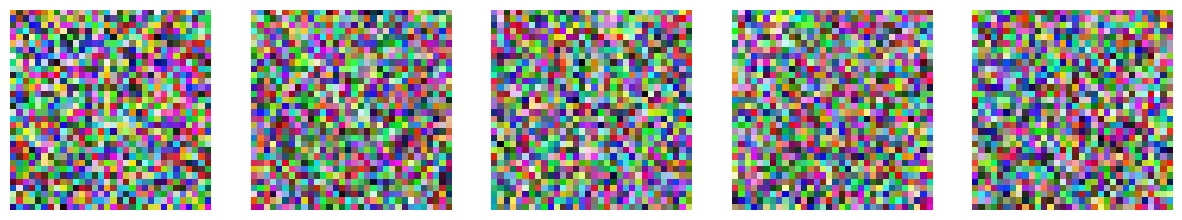

In [5]:
########## YOUR SOLUTION HERE ##########
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def backward_diffusion(vdm, T, alpha, device):
    alpha = torch.tensor(alpha, device=device)
    vdm.load_state_dict(torch.load('vdm_model.pth'))
    vdm.to(device)
    vdm.eval()
    x_t = torch.randn(1, 3, 32, 32, device=device) 

    images = [x_t.cpu().detach().numpy()]
    
    for t in reversed(range(1, T + 1)):
        with torch.no_grad():
            t_normalized = torch.tensor([[t / T * 2 - 1]], device=device)
            hat_x_0 = vdm(x_t, t_normalized)

        alpha_t = alpha ** t
        alpha_t_minus_1 = alpha ** (t - 1)
        sqrt_alpha = torch.sqrt(alpha)
        sqrt_alpha_t_minus_1 = torch.sqrt(alpha_t_minus_1)
        one_minus_alpha_t = 1 - alpha_t
        one_minus_alpha_t_minus_1 = 1 - alpha_t_minus_1
        one_minus_alpha = 1 - alpha

        mean = ((sqrt_alpha * one_minus_alpha_t_minus_1 * x_t + 
                 sqrt_alpha_t_minus_1 * one_minus_alpha * hat_x_0) / one_minus_alpha_t)
        std_dev = torch.sqrt((one_minus_alpha * one_minus_alpha_t_minus_1) / one_minus_alpha_t)

        x_t_minus_1 = mean + std_dev * torch.randn_like(x_t)
        images.append(x_t_minus_1.cpu().detach().numpy())
        x_t = x_t_minus_1
    
    return images

images = backward_diffusion(vdm, T, alpha, device)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(transforms.ToPILImage()(torch.tensor(images[-1 - i * T//4]).squeeze(0)))
    ax.axis('off')
plt.show()
